In [ ]:
# enable logging widget
%load_ext pymor.discretizers.builtin.gui.jupyter

from IPython.display import Image, display

# System-theoretic Methods with pyMOR

## Our Goal

We want to do model order reduction (MOR) for *input-output control systems*.

This means:

- We are given a full-order model (FOM) as an input-output system $\Sigma\colon u\mapsto y$.
  
  ![](figures/system_fom.svg)
- We can simulate/solve the FOM for any given input $u\colon[0,\infty)\to\mathbb{R}^m$. But this is costly.
- We want to simulate the model, i.e. compute its output $y$, for many different $u$.

**Task:**

- Replace the FOM by a surrogate reduced-order model (ROM).
- The ROM should be much faster to simulate/solve.
- The error between the ROM and FOM solution should be small and controllable.

Note: In this tutorial we will only cover the mere basics of projection-based reduction methods. The approach has been extended to other types of models (discrete-time systems, differential-algebraic systems, nonlinear systems, parametric systems, ...) and is largely independent of the specific choice of discretization method.

## Background: Linear Time-Invariant (LTI) Systems

### First-order State-space Systems (pyMOR: [`LTIModel`](https://docs.pymor.org/main/autoapi/pymor/models/iosys/index.html#pymor.models.iosys.LTIModel))

$$
\begin{equation}\tag{$\Sigma$}
  \begin{aligned}
    E \dot{x}(t) & = A x(t) + B u(t), \\
    y(t) & = C x(t) + D u(t).
  \end{aligned}
\end{equation}
$$

Here

- $x(t) \in \mathbb{R}^{n}$ is called the *state*,
- $u(t) \in \mathbb{R}^{m}$ is called the *input*,
- $y(t) \in \mathbb{R}^{p}$ is called the *output*

of the LTI system.
Correspondingly, we have

$$
\begin{align*}
  E, A \in \mathbb{R}^{n \times n}, \qquad
  B \in \mathbb{R}^{n \times m}, \qquad
  C \in \mathbb{R}^{p \times n}, \quad\text{and}\quad
  D \in \mathbb{R}^{p \times m}.
\end{align*}
$$

We assume
$t \in [0, \infty)$,
$x(0) = 0$,
$E$ is invertible,
$E^{-1} A$ is Hurwitz (i.e. all eigenvalues of $E^{-1}A$ have negative real part and the system is therefore asymptotically stable), and
$D = 0$.

## Building the FOM

### Heat equation

We consider the following one-dimensional heat equation over {math}`(0, 1)` with
two inputs {math}`u_1, u_2` and three outputs {math}`y_1, y_2, y_2`:

```{math}
\begin{align}
    \partial_t T(\xi, t) & = \partial_{\xi \xi} T(\xi, t) + u_1(t),
    & 0 < \xi < 1,\ t > 0, \\
    -\partial_\xi T(0, t) & = -T(0, t) + u_2(t),
    & t > 0, \\
    \partial_\xi T(1, t) & = -T(1, t),
    & t > 0, \\
    y_k(t) & = 3 \int_{\frac{k - 1}{3}}^{\frac{k}{3}} T(\xi, t) \, \mathrm{d}\xi,
    & t > 0,\ k = 1, 2, 3.
\end{align}
```

There are many ways of building an `LTIModel`.
Here, we will use the
`from_matrices` method of `LTIModel`,
which instantiates an `LTIModel` from NumPy or SciPy matrices.

In [1]:
import numpy as np
import scipy.sparse as sps

k = 50
n = 2 * k + 1

E = sps.eye(n, format='lil')
E[0, 0] = E[-1, -1] = 0.5
E = E.tocsc()

d0 = n * [-2 * (n - 1)**2]
d1 = (n - 1) * [(n - 1)**2]
A = sps.diags([d1, d0, d1], [-1, 0, 1], format='lil')
A[0, 0] = A[-1, -1] = -n * (n - 1)
A = A.tocsc()

B = np.zeros((n, 2))
B[:, 0] = 1
B[0, 0] = B[-1, 0] = 0.5
B[0, 1] = n - 1

C = np.zeros((3, n))
C[0, :n//3] = C[1, n//3:2*n//3] = C[2, 2*n//3:] = 1
C /= C.sum(axis=1)[:, np.newaxis]

In [2]:
from pymor.models.iosys import LTIModel
fom = LTIModel.from_matrices(A, B, C, E=E)

In [3]:
fom

LTIModel(
    NumpyMatrixOperator(<101x101 sparse, 301 nnz>),
    NumpyMatrixOperator(<101x2 dense>),
    NumpyMatrixOperator(<3x101 dense>),
    D=ZeroOperator(NumpyVectorSpace(3), NumpyVectorSpace(2)),
    E=NumpyMatrixOperator(<101x101 sparse, 101 nnz>),
    presets={})

In [4]:
print(fom)

LTIModel
    class: LTIModel
    number of equations: 101
    number of inputs:    2
    number of outputs:   3
    continuous-time
    linear time-invariant
    solution_space:  NumpyVectorSpace(101)


We can perform time-domain simulation, but the final time and the time stepper
need to be specified in the `Model`.

In [5]:
from pymor.algorithms.timestepping import ImplicitEulerTimeStepper

fom = fom.with_(T=4, time_stepper=ImplicitEulerTimeStepper(200))

With this done, we can compute the output for some given input and plot it.

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

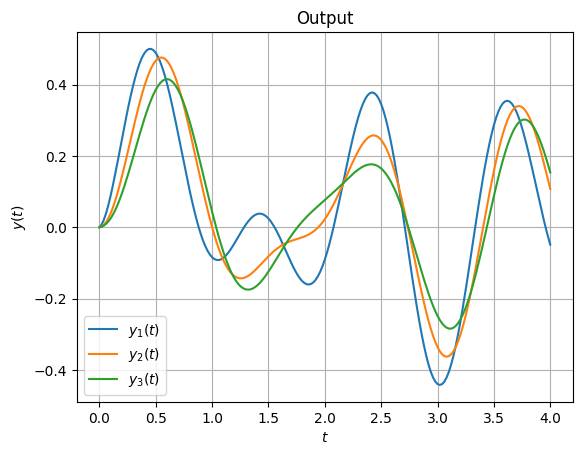

In [6]:
Y = fom.output(input='[sin(4 * t[0]), sin(6 * t[0])]')

import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True

fig, ax = plt.subplots()
for i, y in enumerate(Y.T):
    ax.plot(np.linspace(0, fom.T, fom.time_stepper.nt + 1), y, label=f'$y_{i+1}(t)$')
_ = ax.set(xlabel='$t$', ylabel='$y(t)$', title='Output')
_ = ax.legend()

Next, we simulate the impulse response, i.e.,
the output in response to $x(0) = 0$ and $u(t) = \delta(t)$:

$$
\begin{align*}
  y(t)
  & =
    C e^{t E^{-1} A} x(0)
    + \int_0^T C e^{\tau E^{-1} A} E^{-1} B u(t - \tau) \operatorname{d\!}\tau \\
  & =
    C e^{t E^{-1} A} E^{-1} B
\end{align*}
$$

In [7]:
y_impulse = fom.impulse_resp()
print(y_impulse.shape)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

(201, 3, 2)


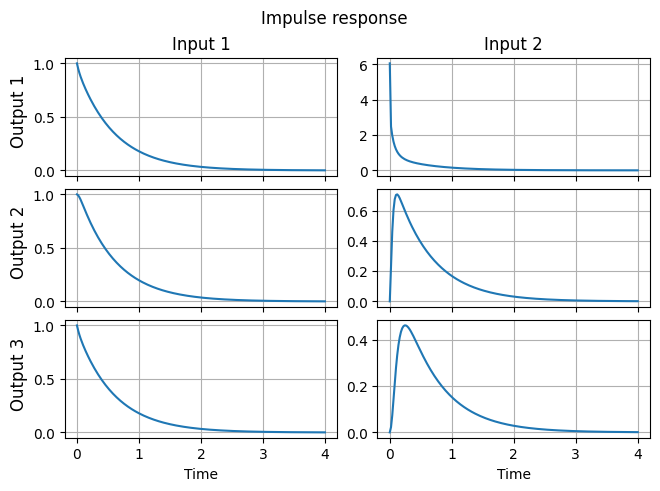

In [8]:
fig, ax = plt.subplots(fom.dim_output, fom.dim_input, sharex=True, constrained_layout=True)
for i in range(fom.dim_output):
    for j in range(fom.dim_input):
        ax[i, j].plot(np.linspace(0, fom.T, y_impulse.shape[0]), y_impulse[:, i, j])
for i in range(fom.dim_output):
    ax[i, 0].set_title(f'Output {i + 1}', loc='left', rotation='vertical', x=-0.2, y=0.2)
for j in range(fom.dim_input):
    ax[0, j].set_title(f'Input {j + 1}')
    ax[-1, j].set_xlabel('Time')
_ = fig.suptitle('Impulse response')

# Transfer Function

## Laplace Transform

> ### Definition
>
> Let $f \colon [0, \infty) \to \mathbb{R}^{n}$ be exponentially bounded with
> bounding exponent $\alpha$.
> Then
> $$\mathcal{L}\{f\}(s) := \int_0^\infty f(\tau) e^{-s \tau} \operatorname{d}\!{\tau}$$
> for $\operatorname{Re}(s) > \alpha$ is called the ***Laplace transform*** of $f$.
> The process of forming the Laplace transform is called
> ***Laplace transformation***.

It can be shown that the integral converges uniformly in a domain with
$\operatorname{Re}(s) \ge \beta$ for all $\beta > \alpha$.

> Allows us to map time signals to frequency signals.

> ### Theorem
>
> Let $f, g, h \colon [0, \infty) \to \mathbb{R}^n$ be given.
> Then the following two statements hold true:
>
> 1. The Laplace transformation is linear, i.e.,
>    if $f$ and $g$ are exponentially bounded,
>    then $h := \gamma f + \delta g$ is also exponentially bounded and
>
>    $$
     \mathcal{L}\left\{h\right\} = \gamma\mathcal{L}\left\{f\right\} +
     \delta\mathcal{L}\left\{g\right\}
     $$
>
>    holds for all $\gamma, \delta \in \mathbb{C}$.
> 2. If $f \in \mathcal{PC}^1([0, \infty), \mathbb{R}^{n})$ and $\dot{f}$ is
>    exponentially bounded, then $f$ is exponentially bounded and
>
>    $$
     \mathcal{L}\bigl\{\dot{f}\bigr\}(s) = s \mathcal{L}\{f\}(s) - f(0).
     $$

- $X(s) := \mathcal{L}\{x\}(s)$,
  $U(s) := \mathcal{L}\{u\}(s)$, and
  $Y(s) := \mathcal{L}\{y\}(s)$
- $A x(t) + B u(t) \leadsto A X(s) + B U(s)$
- $y(t) = C x(t) \leadsto Y(s) = C X(s)$
- $s X(s) = \mathcal{L}\{\dot{x}\}(s)$ (since $x(0) = 0$)

## Transfer Function

In summary we have:

- $s E X(s) = A X(s) + B U(s)$
- $Y(s) = C X(s)$

Thus the mapping from inputs to outputs in frequency domain can be expressed as

$$
H(s) = C {\left(s E - A\right)}^{-1} B,
$$

i.e.

$$
Y(s) = H(s) U(s).
$$

The transfer function $H$ is analytic in $\mathbb{C} \setminus \Lambda(E, A)$.

### Example

In [9]:
fom.transfer_function

FactorizedTransferFunction(
    2,
    3,
    LincombOperator(
        (NumpyMatrixOperator(<101x101 sparse, 101 nnz>), NumpyMatrixOperator(<101x101 sparse, 301 nnz>)),
        (ProjectionParameterFunctional('s', index=0), -1.0)),
    NumpyMatrixOperator(<101x2 dense>),
    NumpyMatrixOperator(<3x101 dense>),
    ZeroOperator(NumpyVectorSpace(3), NumpyVectorSpace(2)),
    dK=NumpyMatrixOperator(<101x101 sparse, 101 nnz>),
    dB=ZeroOperator(NumpyVectorSpace(101), NumpyVectorSpace(2)),
    dC=ZeroOperator(NumpyVectorSpace(3), NumpyVectorSpace(101)),
    dD=ZeroOperator(NumpyVectorSpace(3), NumpyVectorSpace(2)),
    name='LTIModel_transfer_function')

In [10]:
fom.transfer_function.eval_tf(0)

array([[0.56266667, 0.61333333],
       [0.620175  , 0.50166667],
       [0.564075  , 0.38833333]])

In [11]:
fom.transfer_function.eval_tf(1)

array([[0.35516035, 0.42800414],
       [0.39053974, 0.30625375],
       [0.35602872, 0.21798312]])

In [12]:
fom.transfer_function.eval_tf(1j)

array([[0.41916591-0.24498821j, 0.49022668-0.21786001j],
       [0.46133002-0.27112399j, 0.36609293-0.23081817j],
       [0.42019995-0.24562591j, 0.26612665-0.20191321j]])

### Frequency-Domain Analysis

It is known that if the input is chosen as
{math}`u(t) = a e^{\xi t} \sin(\omega t + \varphi) e_j`
(where {math}`e_j` is the {math}`j`-th canonical vector),
then

```{math}
\lim_{t \to \infty}
\left(
  y_i(t)
  - a \lvert H_{ij}(\xi + \boldsymbol{\imath} \omega) \rvert e^{\xi t}
  \sin(\omega t + \varphi + \arg(H_{ij}(\xi + \boldsymbol{\imath} \omega)))
\right)
= 0.
```

In words, if the input is a pure exponential,
the frequency is preserved in the output,
the amplitude is multiplied by the amplitude of the transfer function, and
the phase is shifted by the argument of the transfer function.

It is of interest to plot the transfer function over the imaginary axis to
visualize how the LTI system responds to each frequency in the input.
Since the transfer function is complex-valued (and matrix-valued),
there are multiple ways to plot it.

#### Bode Plots

The Bode plot for $H$ consists of a ***magnitude plot*** and a ***phase plot***.

> ##### Bode magnitude plot
>
> - component-wise graph of the function $\lvert H(\boldsymbol{\imath} \omega) \rvert$
>   for frequencies $\omega \in [\omega_{\min}, \omega_{\max}] \subset \mathbb{R}$.
> - $\omega$-axis is logarithmic.
> - magnitude is given in decibels, i.e., $\lvert H(\boldsymbol{\imath} \cdot) \rvert$ is
>   plotted as $20 \log_{10}(\lvert H(\boldsymbol{\imath} \cdot) \rvert)$.

> ##### Bode phase plot
>
> - component-wise graph of the function $\arg{H(\boldsymbol{\imath} \omega)}$
>   for frequencies $\omega \in [\omega_{\min}, \omega_{\max}] \subset \mathbb{R}$.
> - $\omega$-axis is logarithmic.
> - phase is given in degrees on a linear scale.

In [13]:
# w = (1e-2, 1e3)
w, _ = fom.transfer_function.freq_resp((1e-2, 1e3))

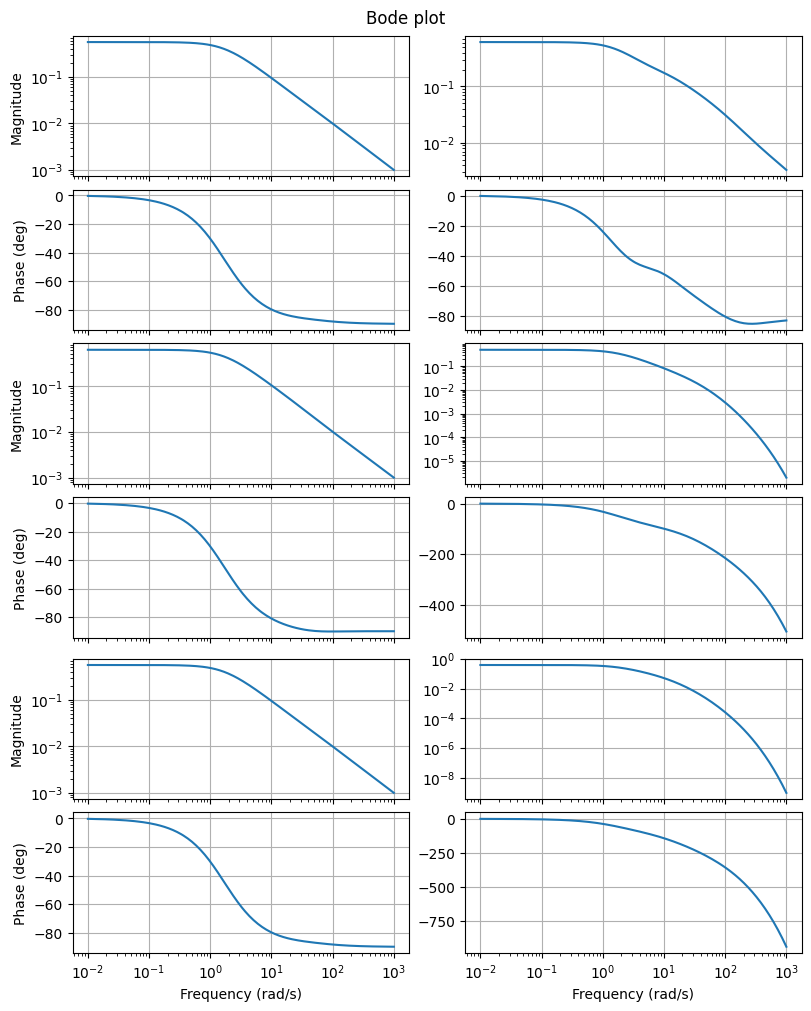

In [14]:
fig, axs = plt.subplots(6, 2, figsize=(8, 10), sharex=True, constrained_layout=True)
_ = fom.transfer_function.bode_plot(w, ax=axs)

> #### (Sigma) Magnitude Plots
>
> - 2-norm-wise graph of the function $H(\boldsymbol{\imath} \omega)$
>   for frequencies $\omega \in [\omega_{\min}, \omega_{\max}] \subset \mathbb{R}$.
> - $\omega$-axis is logarithmic.

The name is due to the fact that for a given matrix $M$ the norm
$\lVert M \rVert_2$ is given by its largest singular value.

The real sigma magnitude plot depicts all singular values as functions of
$\omega$.

In [ ]:
_ = fom.transfer_function.mag_plot(w)

## Projection-based MOR

### Ritz/Petrov-Galerkin Projection

$$
\begin{align*}
  E \dot{x}(t) - A x(t) - B u(t) & = 0, \\
  y(t) - C x(t) - D u(t) & = 0.
\end{align*}
$$

**Step I: Use truncated state transformation**

Replace

$$
x(t) \approx V \hat{x}(t)
$$

with $V \in \mathbb{R}^{n \times r}$ and $\hat{x}(t) \in \mathbb{R}^{r}$.

$$
\begin{align*}
  E V \dot{\hat{x}}(t) - A V \hat{x}(t) - B u(t) & = e_{\text{res}}(t), \\
  y(t) - C V \hat{x}(t) - D u(t) & = e_{\text{output}}(t).
\end{align*}
$$

**Step II: Mitigate transformation error**

Suppress truncation residual through left projection.

- one-sided method: use $V$ again.

  $$
  \begin{align*}
    V^{\operatorname{T}} E V \dot{\hat{x}}(t)
    - V^{\operatorname{T}} A V \hat{x}(t)
    - V^{\operatorname{T}} B u(t)
    & = 0, \\
    y(t) - C V \hat{x}(t) - D u(t) & = e_{\text{output}}(t).
  \end{align*}
  $$

- two-sided method: find $W \in \mathbb{R}^{n \times r}$.

  $$
  \begin{align*}
    W^{\operatorname{T}} E V \dot{\hat{x}}(t)
    - W^{\operatorname{T}} A V \hat{x}(t)
    - W^{\operatorname{T}} B u(t)
    & = 0, \\
    y(t) - C V \hat{x}(t) - D u(t) & = e_{\text{output}}(t).
  \end{align*}
  $$

![](figures/mor_system_fo_v2.svg)

### Reduced order model (ROM) (pyMOR: [`LTIPGReductor`](https://docs.pymor.org/main/autoapi/pymor/reductors/basic/index.html?highlight=ltipgred#pymor.reductors.basic.LTIPGReductor))

Define
$\hat{E} = W^{\operatorname{T}} E V$,
$\hat{A} = W^{\operatorname{T}} A V \in \mathbb{R}^{r \times r}$,
$\hat{B} = W^{\operatorname{T}} B \in \mathbb{R}^{r \times m}$, and
$\hat{C} = C V \in \mathbb{R}^{p \times r}$.
Then

$$
\begin{equation}\tag{ROM}
  \begin{aligned}
    \hat{E} \dot{\hat{x}}(t) & = \hat{A} \hat{x}(t) + \hat{B} u(t), \\
    \hat{y}(t) & = \hat{C} \hat{x}(t) + D u(t)
  \end{aligned}
\end{equation}
$$

approximates the dynamics of the full-order model $\Sigma$ with output error

$$
y(t) - \hat{y}(t) = e_{\text{output}}(t).
$$

- We call the corresponding transfer function $\hat{H}$.
- Model order reduction $\leadsto$
  Find $W, V \in \mathbb{R}^{n \times r}$ such that $e_{\text{output}}(t)$ is
  small in a suitable sense.
- We will focus on energy-based methods.

### Example

In [15]:
from pymor.reductors.basic import LTIPGReductor

V = fom.solution_space.random(10)
pg = LTIPGReductor(fom, V, V)
rom_pg = pg.reduce()

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The resulting model `rom_pg` will again be an `LTIModel`.

In [16]:
rom_pg

LTIModel(
    NumpyMatrixOperator(<10x10 dense>),
    NumpyMatrixOperator(<10x2 dense>),
    NumpyMatrixOperator(<3x10 dense>),
    D=ZeroOperator(NumpyVectorSpace(3), NumpyVectorSpace(2)),
    E=NumpyMatrixOperator(<10x10 dense>),
    T=4,
    initial_data=VectorOperator(
                     NumpyVectorArray(NumpyVectorSpace(10), [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], _len=1),
                     name='initial_data'),
    time_stepper=ImplicitEulerTimeStepper(200),
    presets={},
    name='LTIModel_reduced')

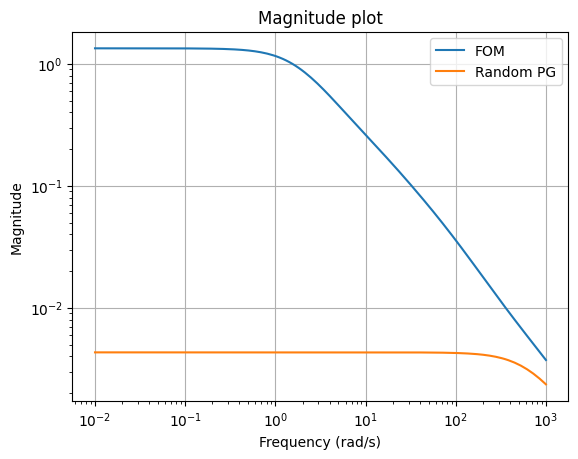

In [17]:
_ = fom.transfer_function.mag_plot(w, label='FOM')
_ = rom_pg.transfer_function.mag_plot(w, label='Random PG')
_ = plt.legend()

# System Analysis

## System Norms and Hardy Spaces

We have $$Y(s) = H(s) U(s)$$ and $$\hat{Y}(s) = \hat{H}(s) U(s).$$

> ### Question
>
> What are suitable norms such that
>
> $$
  \lVert y - \hat{y} \rVert
  \le
  \left\lVert H - \hat{H} \right\rVert
  \lVert u \rVert?
  $$

### The Banach Space $\mathcal{H}_\infty^{p \times m}$

$$
\mathcal{H}_\infty^{p \times m}
:=
\left\{
  G \colon \mathbb{C}^+ \to \mathbb{C}^{p \times m} :
  G \text{ is analytic in $\mathbb{C}^+$ and }
  \sup_{s \in \mathbb{C}^+} \left\lVert G(s) \right\rVert_2 < \infty
\right\}.
$$

$\mathcal{H}_\infty^{p \times m}$ is a Banach space equipped with the
***$\mathcal{H}_\infty$-norm***

$$
\left\lVert G \right\rVert_{\mathcal{H}_\infty}
:= \sup_{\omega \in \mathbb{R}}
\left\lVert G(\boldsymbol{\imath} \omega) \right\rVert_2.
$$

> Can show:
>
> $$
  \lVert y - \hat{y} \rVert_{\mathcal{L}_{2}}
  \le
  \left\lVert H - \hat{H} \right\rVert_{\mathcal{H}_{\infty}}
  \lVert u \rVert_{\mathcal{L}_{2}}.
  $$

This bound can even be shown to be sharp.

In [18]:
fom.hinf_norm()

1.3351147226114526

### The Hilbert Space $\mathcal{H}_2^{p \times m}$

$$
\mathcal{H}_2^{p \times m}
:= \left\{
  G \colon \mathbb{C}^+ \to \mathbb{C}^{p \times m} :
  G \text{ is analytic in $\mathbb{C}^+$ and }
  \sup_{\xi > 0}
  \int_{-\infty}^\infty
  \left\lVert
  G(\xi + \boldsymbol{\imath} \omega)
  \right\rVert_{\operatorname{F}}^2
  \operatorname{d}\!{\omega}
  < \infty
\right\}.
$$

$\mathcal{H}_2^{p \times m}$ is a Hilbert space with the inner product

$$
\langle F, G \rangle_{\mathcal{H}_2}
:=
\frac{1}{2 \pi}
\int_{-\infty}^\infty
\operatorname{tr}\!\left(
  {F(\boldsymbol{\imath} \omega)}^{\operatorname{H}}
  G(\boldsymbol{\imath} \omega)
\right)
\operatorname{d}\!{\omega}
$$

and induced norm

$$
\left\lVert G \right\rVert_{\mathcal{H}_2}
:= \langle G, G \rangle_{\mathcal{H}_2}^{1/2}
= {
  \left(
    \frac{1}{2 \pi}
    \int_{-\infty}^\infty
    \left\lVert G(\boldsymbol{\imath} \omega) \right\rVert_{\operatorname{F}}^2
    \operatorname{d}\!{\omega}
  \right)
}^{1/2}.
$$

> Can show:
>
> $$
  \lVert y - \hat{y} \rVert_{\mathcal{L}_{\infty}}
  \le
  \left\lVert H - \hat{H} \right\rVert_{\mathcal{H}_{2}}
  \lVert u \rVert_{\mathcal{L}_{2}}.
  $$

In [19]:
fom.h2_norm()

1.31488196406485

### System Gramians and $\mathcal{H}_{2}$ trace formula

A system $\Sigma$ with $\Lambda(E, A) \subset \mathbb{C}^{-}$ is called
***asymptotically stable***.
Then, all state trajectories decay exponentially as $t \to \infty$ and

- the infinite controllability and observability ***Gramians*** exist:

  $$
  \begin{align*}
    P
    & =
      \int_0^{\infty}
      e^{E^{-1} A t}
      E^{-1}
      B B^{\operatorname{T}}
      E^{-\operatorname{T}}
      e^{A^{\operatorname{T}} E^{-\operatorname{T}} t}
      \operatorname{d}\!{t} \\
    E^{\operatorname{T}} Q E
    & =
      \int_0^{\infty}
      e^{A^{\operatorname{T}} E^{-\operatorname{T}} t}
      C^{\operatorname{T}} C
      e^{E^{-1} A t}
      \operatorname{d}\!{t}.
  \end{align*}
  $$
- $P$, $Q$ solve the two ***Lyapunov equations***

  $$
  A P E^{\operatorname{T}} + E P A^{\operatorname{T}} + B B^{\operatorname{T}} = 0, \qquad
  A^{\operatorname{T}} Q E + E^{\operatorname{T}} Q A + C^{\operatorname{T}} C = 0
  $$
<!-- - If $(A, B)$ is controllable and $(A, C)$ is observable, -->
<!--   it moreover holds that $P = P^{\operatorname{T}} \succ 0$ and $Q = Q^{\operatorname{T}} \succ 0$. -->
<!--   (Otherwise we just have $P = P^{\operatorname{T}} \succcurlyeq 0$ and -->
<!--   $Q = Q^{\operatorname{T}} \succcurlyeq 0$.) -->
- the $\mathcal{H}_{2}$-norm can be expressed as

  $$
  \lVert H \rVert_{\mathcal{H}_{2}}^{2}
  = \operatorname{tr}\!\left(C P C^{\operatorname{T}}\right)
  = \operatorname{tr}\!\left(B^{\operatorname{T}} Q B\right).
  $$

The Gramians can be used to quantify how much does the input influence the state
(controllability) and state the output (observability).

#### Energy-based interpretation of the Gramians

**Controllability Gramian $P$:**
Energy needed to reach the state $x_0$ from $0$.
$$
    x_0^\top P^{-1} x_0 = \min_u\ \lVert u\rVert^2_{L^2(-\infty,0)}
$$

**Observability Gramian $Q$:**
Energy returned by the state $x_0$ with $u\equiv 0$.
$$
    x_0^\top Q x_0 = \lVert y\rVert^2_{L^2(0,\infty)}
$$

## Balancing-based MOR

### Balanced Truncation aka. Lyapunov Balancing

#### Idea

- The system $\Sigma$, in realization $(E = I, A, B, C)$,
  is called ***balanced***, if the solutions $P, Q$ of the Lyapunov equations

  $$
  A P + P A^{\operatorname{T}} + B B^{\operatorname{T}} = 0, \qquad
  A^{\operatorname{T}} Q + Q A + C^{\operatorname{T}} C = 0,
  $$

  satisfy:
  $P = Q = \operatorname{diag}(\sigma_1, \ldots, \sigma_n)$
  where
  $\sigma_1 \ge \sigma_2 \ge \cdots \ge \sigma_n > 0$.

- $\{\sigma_1, \ldots, \sigma_n\}$ are the *Hankel singular values (HSVs)* of
  $\Sigma$.

- A so-called ***balanced realization*** is computed via state-space transformation

  $$
  \begin{align*}
    \mathcal{T} \colon (I, A, B, C) \mapsto {} & (I, T A T^{-1}, T B, C T^{-1}) \\
    & =
      \left(
        I,
        \begin{bmatrix}
          A_{11} & A_{12} \\
          A_{21} & A_{22}
        \end{bmatrix},
        \begin{bmatrix}
          B_{1} \\
          B_{2}
        \end{bmatrix},
        \begin{bmatrix}
          C_{1} & C_{2}
        \end{bmatrix}
      \right).
  \end{align*}
  $$

- In a balanced realization the state variables are sorted based on their
  contribution to the input-output mapping.

- Truncation removes state variables which are not important for input-output
  behavior $\leadsto$ reduced order model:
  $(I, \hat{A}, \hat{B}, \hat{C}) = (I, A_{11}, B_{1}, C_{1})$.

### Implementation: The Square Root Method

#### The SR Method (pyMOR: [`BTReductor`](https://docs.pymor.org/main/autoapi/pymor/reductors/bt/index.html?highlight=btreductor#pymor.reductors.bt.BTReductor))

1. Compute (Cholesky) factors of the solutions to the Lyapunov equation,

   $$
   P = S^{\operatorname{T}} S, \quad
   Q = R^{\operatorname{T}} R.
   $$

2. Compute singular value decomposition

   $$
   S R^{\operatorname{T}}
   =
   \begin{bmatrix}
     U_1 & U_2
   \end{bmatrix}
   \begin{bmatrix}
     \Sigma_1 & 0 \\
     0 & \Sigma_2
   \end{bmatrix}
   \begin{bmatrix}
     V_1^{\operatorname{T}} \\
     V_2^{\operatorname{T}}
   \end{bmatrix}.
   $$

3. Define

   $$
   W := R^{\operatorname{T}} V_1 \Sigma_1^{-1/2}, \quad
   V := S^{\operatorname{T}} U_1 \Sigma_1^{-1/2}.
   $$
4. Then the reduced-order model is
   $(W^{\operatorname{T}} A V, W^{\operatorname{T}} B, C V)$.

#### Properties

- Lyapunov balancing **preserves asymptotic stability**.
- We have the **a priori error bound**:
  $$
  \left\lVert H - \hat{H} \right\rVert_{\mathcal{H}_{\infty}}
  \le
  2 \sum\limits_{k = r + 1}^{n} \sigma_{k}
  $$

In [20]:
from pymor.reductors.bt import BTReductor

bt = BTReductor(fom)
rom = bt.reduce(10)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

In [21]:
rom

LTIModel(
    NumpyMatrixOperator(<10x10 dense>),
    NumpyMatrixOperator(<10x2 dense>),
    NumpyMatrixOperator(<3x10 dense>),
    D=ZeroOperator(NumpyVectorSpace(3), NumpyVectorSpace(2)),
    E=NumpyMatrixOperator(<10x10 dense>),
    T=4,
    initial_data=VectorOperator(
                     NumpyVectorArray(NumpyVectorSpace(10), [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], _len=1),
                     name='initial_data'),
    time_stepper=ImplicitEulerTimeStepper(200),
    presets={},
    name='LTIModel_reduced')

Let us compare the Magnitude plots of the FOM and the ROM:

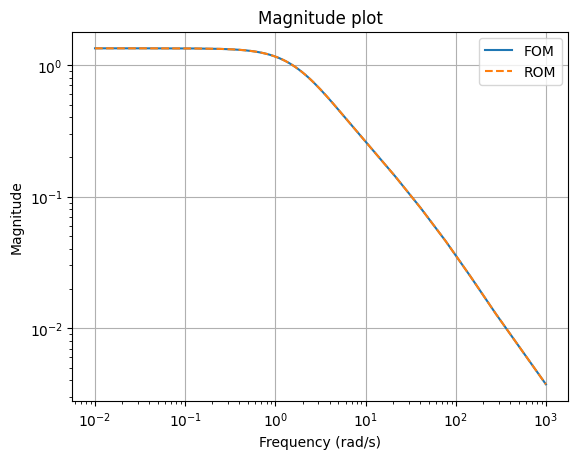

In [22]:
w = (1e-2, 1e3)
fig, ax = plt.subplots()
fom.transfer_function.mag_plot(w, ax=ax, label='FOM')
rom.transfer_function.mag_plot(w, ax=ax, linestyle='--', label='ROM')
_ = ax.legend()

And the Bode plots:

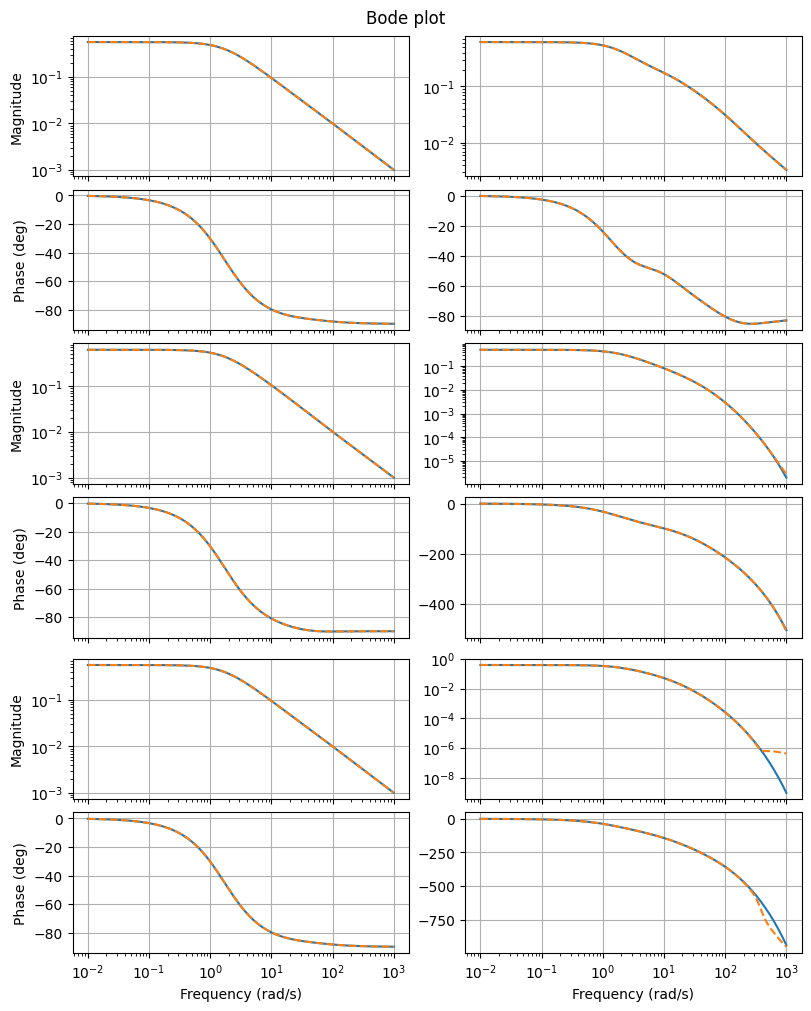

In [23]:
fig, axs = plt.subplots(6, 2, figsize=(8, 10), sharex=True, constrained_layout=True)
fom.transfer_function.bode_plot(w, ax=axs)
_ = rom.transfer_function.bode_plot(w, ax=axs, linestyle='--')

In [24]:
err = fom - rom

Finally, we can compute the relative errors in different system norms:

In [25]:
print(f'Relative Hinf error:   {err.hinf_norm() / fom.hinf_norm():.3e}')
print(f'Relative H2 error:     {err.h2_norm() / fom.h2_norm():.3e}')

Relative Hinf error:   1.236e-06
Relative H2 error:     6.797e-05


#### Variants (pyMOR: [`PRBTReductor`](https://docs.pymor.org/main/autoapi/pymor/reductors/bt/index.html?highlight=btreductor#pymor.reductors.bt.PRBTReductor), [`BRBTReductor`](https://docs.pymor.org/main/autoapi/pymor/reductors/bt/index.html?highlight=btreductor#pymor.reductors.bt.BRBTReductor), [`LQGBTReductor`](https://docs.pymor.org/main/autoapi/pymor/reductors/bt/index.html?highlight=btreductor#pymor.reductors.bt.LQGBTReductor))

Other versions for special classes of systems or applications exist, such as

- **positive-real balancing** (passivity-preserving),
- **bounded-real balancing** (contractivity-preserving),
- **linear-quadratic Gaussian balancing**
  (stability preserving, aims at low-order output feedback controllers).

The given ones all compute $P, Q$ as solutions of ***algebraic Riccati
equations*** of the form:

$$
\begin{align*}
  0
  & =
    \tilde{A} P \tilde{E}^{\operatorname{T}}
    + \tilde{E} P \tilde{A}^{\operatorname{T}}
    + \tilde{B} \tilde{B}^{\operatorname{T}}
    \pm \tilde{E} P \tilde{C}^{\operatorname{T}} \tilde{C} P \tilde{E}^{\operatorname{T}} \\
  0
  & =
    \tilde{A}^{\operatorname{T}} Q \tilde{E}
    + \tilde{E}^{\operatorname{T}} Q \tilde{A}
    + \tilde{C}^{\operatorname{T}} \tilde{C}
    \pm \tilde{E}^{\operatorname{T}} Q \tilde{B} \tilde{B}^{\operatorname{T}} Q \tilde{E}.
\end{align*}
$$

## Further methods implemented in pyMOR

- **Modal truncation:** Based on eigenvalues of $A$; does not take input and output into account.
- **Interpolatory methods such as IRKA:** Based on interpolation of the transfer function.
- **Methods for particular systems:** Port-Hamiltonian systems (structure preserving MOR), second order systems, etc.